# Introduction


This is a short overview over the features of the `quantumsim` package, from the perspective of a user.

## Circuits

`quantumsim.circuit` contains the `Circuit` class, which hold a set of named qubits (but not their state) and a sequence of gates that are applied to the qubits. As an example, a CNOT can be implemented using a CZ and Hadamard gates like this:


In [2]:
import numpy as np
from quantumsim.circuit import Circuit

t1, t2 = 3000, 1500

c = Circuit(title="CNOT gate")
c.add_qubit("A", t1, t2)
c.add_qubit("B", t1, t2)

c.add_hadamard("B", time=0)
c.add_hadamard("B", time=40)
c.add_cphase("A", "B", time=20);

As you can see, qubits take T1 and T2 arguments. They are however only used when explicitly requested from the Circuit, more on that later.

Also, all times are measured in an arbitrary unit, but make sure to be consistent, for instance use nanoseconds everywhere.

The circuit can be plotted, using `matplotlib`:

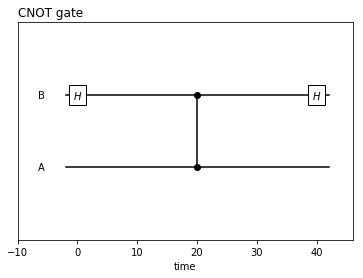

In [3]:
%matplotlib inline
c.plot();

# Measurements

Measurement gates are added as any other gate, but they require additional information in form of a "sampler".
The sampler specifies how the measurement outcomes (and declared outcomes) are determined.

Here, we use a "uniform noisy sampler", which will use a random number generator to sample from 
the projection probabilities (as expected in an experiment), but also sometimes (we choose 3%) declares the wrong outcome.

In order to obtain the declared outcome, we create a bit that obtains the measurement output. 
It is formally a qubit, but since is never put in a superposition, it will be efficiently implemented.


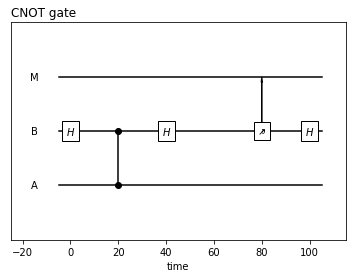

In [4]:
from quantumsim.circuit import uniform_noisy_sampler

c.add_qubit("M")

sampler = uniform_noisy_sampler(readout_error=0.03, seed=42)

c.add_measurement("B", time=80, output_bit="M", sampler=sampler);

c.add_hadamard("B", time=100)

c.plot();

# Idling gates

Unless noted otherwise, gates are always assumed to be applied perfectly. 
Besides the declaration error of the measurement, we have not yet introduced any source of error.

The main source of error is in fact amplitude and phase damping. These are added automatically as rest gates inbetween any 
two other gates, using the `add_waiting_gates` function. Note that the measurement qubit has no rest gates added,
because we did not specify any `t1`, `t2` when creating it.

Note that amplitude and phase damping is assumed to be Markovian, i.e. phase noise is non-echoable. 
Also note that you must give $T_2$, not $T_\phi$ (and giving $T_2 > 2 T_1$ results in an error).

The added idling gates are represented by crosses and annotated with the idling time.

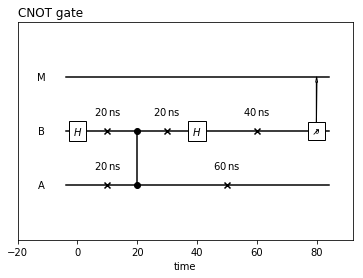

In [4]:
c.add_waiting_gates()
c.plot();

# Simulation

Now we are ready to simulate the circuit. 

The state of the qubits is held in a `quantumsim.sparsedm.SparseDM` object (a "sparse density matrix"), which is where the magic happens.

We create a `SparseDM` with the same qubit names as used in the circuit.

In [5]:
from quantumsim.sparsedm import SparseDM

sdm = SparseDM(c.get_qubit_names())

When loading `sparsedm`, an automatic check is performed whether an NVidia CUDA runtime and the pycuda package are available to perform computation on a GPU. If not, a numpy-based backend is used (thanks to a nice performance boost in `numpy.einsum` in version 1.12). You can check whether the GPU backend is being used:

In [6]:
import quantumsim.sparsedm
print("GPU is used:", quantumsim.sparsedm.using_gpu)

GPU is used: False


Each qubit of the `SparseDM` can be either "classical" or "quantum". If it is classical, its state is 0 or 1 (in computational basis), and not correlated to the state of any other qubit. Initially, all qubits are in the ground state. We flip the control bit A so that something happens.

The state of "Classical" qubits are saved in a simple dictionary, `SparseDM.classical`.

In [7]:
sdm.classical['A'] = 1
print("initial state:", sdm.classical)

initial state: {'M': 0, 'B': 0, 'A': 1}


Now we apply the circuit. Before we can do that, we must instruct the circuit to bring its gates in the correct order.
This essentially orders the Circuits by time, and optimizes for measurements to be performed 'as soon as possible'. 

In [8]:
c.order()
c.apply_to(sdm)

Whenever a gate acts on a qubit, it becomes "quantum", meaning it becomes part of the large density matrix `sdm.full_dm`. Whenever a gate is measured and projected, it becomes classical again. After application of the circuit, the control bit A will thus be quantum. The measured bit B and the declared measurement outcome M should be 1 (unless an error occured), because the CNOT flips B.

In [9]:
print("classical bits after one round:", sdm.classical)

classical bits after one round: {'M': 1, 'B': 1}


Measurements project the density matrix, without renormalizing, we can thus obtain the probability that this measurement outcome actually would be observed:

In [10]:
print("probability:", sdm.trace())

probability: 0.938366690829


Let's run the whole circuit for a number of times and look at the declared outcome to see what happens.

In [11]:
measurements = []

for i in range(150):
    c.apply_to(sdm)
    measurements.append(sdm.classical['M'])

print("150 rounds of outcomes of CNOT-and-measurement:")
print(measurements)

150 rounds of outcomes of CNOT-and-measurement:
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


As we can see, the qubit B toggles each round as long as A is the 1 state, but after a while A decays and the flipping stops. Once during the flipping phase, the qubit decays to 0 while in the 1 state, and then is flipped to 1 again, resulting in two subsequent 1 measurements.

Afterwards, an occasional declaration error is observed.

The probability that exactly this trace is observed is now vanishingly small:

In [12]:
print("probability:", sdm.trace())

probability: 7.6898840428e-12


We can keep the state in `sdm`, but reset this probability:

In [13]:
sdm.renormalize()
print("probability:", sdm.trace())

probability: 1.0


And finally apply one more round and thus obtain the conditional probability of the 152nd measurement outcome given the history of the previous outcomes:

In [14]:
c.apply_to(sdm)
print("152nd measurement:", sdm.classical['M'])
print("conditional probability:", sdm.trace())

152nd measurement: 0
conditional probability: 0.957406624512


The probability is larger than for the first round because the two qubits A and B are in the ground state now, and have less opportunity to decay.

# An example: Bell state preparation

This example is inspired by an actual problem: A resonant C-Z gate is implemented by using a resonator bus as a intermediate qubit with stronger coupling to the other qubit. Using this C-Z gate to generate an entangled state could be described in a circuit like this:

In [15]:
def bell_state_circuit(t1_cp=np.inf, t2_cp=np.inf, t1_bus=np.inf, t2_bus=np.inf, t1_swap=np.inf, t2_swap=np.inf):
    c = quantumsim.circuit.Circuit("Bell state generation")
    c.add_qubit("swap", t1=t1_swap, t2=t2_swap)
    c.add_qubit("bus", t1=t1_bus, t2=t2_bus)
    c.add_qubit("cp", t1=t1_cp, t2=t2_cp)

    c.add_gate(quantumsim.circuit.RotateY("swap", angle=np.pi/2, time=10))
    c.add_gate(quantumsim.circuit.RotateY("cp", angle=np.pi/2, time=40))
    c.add_gate(quantumsim.circuit.ISwap("swap", "bus", time=65))
    c.add_gate(quantumsim.circuit.CPhase("cp", "bus", time=100))
    c.add_gate(quantumsim.circuit.ISwap("swap", "bus", time=135))
    c.add_gate(quantumsim.circuit.RotateY("cp", angle=-np.pi/2, time=190))
    c.add_gate(quantumsim.circuit.ResetGate("bus", time=200, state=0))
    
    c.add_waiting_gates(tmin=0, tmax=200)
    
    c.order()
    return c

Remark: You see that all many gates are available in the `circuit` module (and they are getting more and more). 
The reset gate sets the state of the bus qubit back to zero (also making it classical) and is used here to trace out the state of the resonator from the full density matrix at the end of the calculation.

We are interested in the effect of amplitude and phase damping on the final state.
To verify that we indeed are preparing a Bell state, we first build a clean circuit (no decay), which should generate the target state.

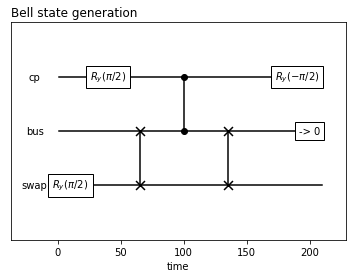

In [56]:
bell_circuit_clean = bell_state_circuit()
bell_circuit_clean.plot()

And here we set the decay times to obtain the circuit with decay:

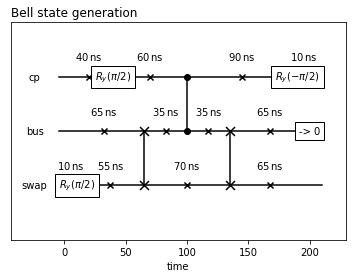

In [25]:
bell_circuit_decay = bell_state_circuit(t1_cp=19000, t2_cp=6000, t1_bus=7000, t2_bus=14000, t1_swap=16000, t2_swap=4000)
bell_circuit_decay.plot()

Now let us apply the clean circuit to a system:

In [34]:
bell_state_clean = quantumsim.sparsedm.SparseDM(bell_circuit_clean.get_qubit_names())
bell_circuit_clean.apply_to(bell_state_clean)

We can obtain the density matrix using `SparseDM.full_dm.to_array()`:

In [37]:
bell_state_clean.full_dm.to_array().round(3)

array([[ 0.5+0.j,  0.0+0.j,  0.0+0.j, -0.5+0.j],
       [ 0.0+0.j,  0.0+0.j,  0.0+0.j, -0.0+0.j],
       [ 0.0+0.j,  0.0+0.j,  0.0+0.j,  0.0+0.j],
       [-0.5+0.j, -0.0+0.j,  0.0+0.j,  0.5+0.j]])

This indeed looks like a Bell state.
It is important to know which qubit is the least significant bit in this density matrix. The choice is done automatically by `SparseDM`. The order is obtainable from `SparseDM.idx_in_full_dm`. Here, the "swap" qubit is the least significant bit.

In [40]:
bell_state_clean.idx_in_full_dm

{'cp': 1, 'swap': 0}

Let us do the same thing for the decaying case:

In [54]:
bell_state_decay = quantumsim.sparsedm.SparseDM(bell_circuit_decay.get_qubit_names())
bell_circuit_decay.apply_to(bell_state_decay)
bell_state_decay.full_dm.to_array().round(3)

array([[ 0.498+0.j,  0.001+0.j, -0.002+0.j, -0.475+0.j],
       [ 0.001+0.j,  0.006+0.j, -0.005+0.j, -0.002+0.j],
       [-0.002+0.j, -0.005+0.j,  0.011+0.j,  0.001+0.j],
       [-0.475+0.j, -0.002+0.j,  0.001+0.j,  0.485+0.j]])

And we see that the density matrix is close, but not perfect, due to the decay.

## Finally, a small hack: fidelity in one line

Internally, density matrices are not stored as (complex, hermitian) density matrices as the one above, but as Pauli vectors (albeit in a somewhat non-standard basis). This means that the fidelity can be obtained in one line by a neat trick, even though this only works if the numpy-based backend is used:

In [58]:
#fidelity
if quantumsim.sparsedm.using_gpu == False:
    print("Bell state fidelity: ", np.dot(bell_state_decay.full_dm.dm.ravel(), bell_state_clean.full_dm.dm.ravel()))

Bell state fidelity:  0.966434515355
